In [210]:
from cassandra.cluster import Cluster
from cassandra.policies import DCAwareRoundRobinPolicy
from cassandra.auth import PlainTextAuthProvider
from cassandra.query import BatchStatement
import pandas as pd

class CassandraType(object):
    PRODUCTION = 0
    TEST = 1
    TEST_DOCKER = 2


class CassandraDAO(object):

    # you have to install following items :
    # a. python-Cassandra driver
    # b. pyspark cassandra connector

    def __init__(self, type):
        print('init CassandraDAO')
        if type == CassandraType.PRODUCTION:
            self.contact_points = ['192.168.95.127', '192.168.95.122']
            self.contact_points_str = "192.168.95.127,192.168.95.122"
        elif type == CassandraType.TEST:
            self.contact_points = ['192.168.0.41', '192.168.0.42']
            self.contact_points_str = "192.168.0.41,192.168.0.42"
        else:
            self.contact_points = ['192.168.0.121', '192.168.0.122', '192.168.0.52']
            self.contact_points_str = "192.168.0.121,192.168.0.122,192.168.0.52"

        self.formatString = "org.apache.spark.sql.cassandra"
        self.username = "username"
        self.password = "password"
        self.cluster = None
        self.session = None
        self.createSession()

    def __del__(self):
        self.cluster.shutdown()

    def pandas_factory(self, colnames, rows):
        return pd.DataFrame(rows, columns=colnames)

    def createSession(self):
        print ("contact_points = " + self.contact_points_str)
        self.cluster = Cluster(
            contact_points=self.contact_points,  # random select a node
            #             load_balancing_policy = DCAwareRoundRobinPolicy(local_dc='datacenter1'),
            #         auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')
        )
        self.session = self.cluster.connect()
        self.session.row_factory = self.pandas_factory
        self.session.default_fetch_size = 10000000
        # needed for large queries, otherwise driver will do pagination. Default is 50000.

    def getSession(self):
        return self.session

    def execCQL(self, keyspace, cql):
        """
        execute CQL
        """
        self.session.set_keyspace(keyspace)
        self.session.execute_async(cql)

    def execCQLSelect(self, keyspace, cql):
        """
        execute CQL, select only
        """

        self.session.set_keyspace(keyspace)

        #       cassandra ResultSet
        async_results = self.session.execute_async(cql)
        return async_results

    def execCQLCallBackAnysc(self, keyspace, cql, handle_success, handle_error):
        """
        execute CQL, if success => handle_success function, else handle_error
        """
        self.session.set_keyspace(keyspace)
        async_results = self.session.execute_async(cql)
        async_results.add_callbacks(handle_success, handle_error)

    def execCQLSelectToPandasDF(self, keyspace, cql):
        """
        execute CQL, select only, return Pandas DataFrame
        """

        self.session.set_keyspace(keyspace)

        #       cassandra ResultSet
        async_results = self.session.execute_async(cql)
        #         async_results = self.session.execute_async(cql)
        #       to Pandas DataFrame
        return async_results.result()._current_rows

    def execCQLSelectToDF(self, sqlContext, keyspace, cql):
        """
        execute CQL, select only, return Spark DataFrame
        """

        #       pandas dataframe to spark dataframe
        pandas_dataframe = self.execCQLSelectToPandasDF(keyspace, cql)
        if pandas_dataframe.empty:
            schema = StructType([])
            return sqlContext.createDataFrame([], schema)
        else:
            return sqlContext.createDataFrame(pandas_dataframe)

    def execCQLSelectToRDD(self, sqlContext, keyspace, cql):
        """
        execute CQL, select only, return Spark RDD
        """

        return self.execCQLSelectToDF(sqlContext, keyspace, cql).rdd.map(tuple)  # dataFrame to RDD

    @property
    def contactPoints(self):
        return self.contact_points

    @contactPoints.setter
    def contactPoints(self, contact_points):
        self.contact_points = contact_points

    @contactPoints.deleter
    def contactPoints(self):
        del self.contact_points

In [211]:
CASSANDRA_ENV = CassandraType.PRODUCTION
c_dao = CassandraDAO(CASSANDRA_ENV)
HELPER_TEST_KEYSPACE='helper_test_keyspace'

init CassandraDAO
contact_points = 192.168.95.127,192.168.95.122


# 1. Import Library

# 資料準備

In [212]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score , roc_auc_score , roc_curve

In [213]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation,Flatten
from keras.layers import Conv1D, GlobalMaxPooling1D,MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers.wrappers import Bidirectional
from keras.callbacks import EarlyStopping
from keras.optimizers import adam
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Dense, Dropout, Embedding, Input, merge, Reshape, Concatenate
from keras.layers import Conv2D, MaxPool2D, Embedding
from keras.utils import np_utils, generic_utils
from keras import optimizers, metrics
from keras.models import Model


from datetime import datetime

import pickle
import numpy as np
import json
import requests
import pandas as pd
pd.set_option('max_colwidth', 100)

# import urllib.request
import os
import tarfile
np.random.seed(10)


In [214]:
# os.chdir("../")
# os.getcwd()

In [215]:
# if not os.path.exists(data_path + "/aclImdb"): 
#     tfile = tarfile.open(data_path + "/aclImdb_v1.tar.gz", 'r:gz')
#     result=tfile.extractall(data_path)

In [216]:
# import re
# re_tag = re.compile(r'<[^>]+>')

# def rm_tags(text):
#     return re_tag.sub('', text)

In [217]:
# import os
# def read_files(filetype):
#     path = data_path + "/aclImdb/" #"data/aclImdb/"
#     file_list=[]

#     positive_path=path + filetype+"/pos/"
#     for f in os.listdir(positive_path):
#         file_list+=[positive_path+f]
    
#     negative_path=path + filetype+"/neg/"
#     for f in os.listdir(negative_path):
#         file_list+=[negative_path+f]
        
#     print('read',filetype, 'files:',len(file_list))
       
#     all_labels = ([1] * 12500 + [0] * 12500) 
    
#     all_texts  = []
    
#     for fi in file_list:
#         with open(fi) as file_input: #with open(fi,encoding='utf8') as file_input:
#             all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
#     return all_labels,all_texts

In [218]:
# row_train_data,row_train_text=read_files("train")

In [219]:
# type(row_train_data),type(row_train_text)

In [220]:
# row_train_data[0],row_train_text[0]

In [221]:
# y_test,test_text=read_files("test")

In [222]:
from collections import namedtuple
import pandas as pd
import jieba
import jieba.posseg as pseg


class JiebaSegmentor:

    def __init__(self, dict_path, userdict=[], stopwords=False, stopwords_path=None):
        self.dict_path = dict_path
        self.userdict = userdict
        self.dictionary_init()
        self.stopwords_path = stopwords_path
        self.stopwords = stopwords
        self.stopwords_set = set()
        self.stopwords_init()

    def dictionary_init(self):
        jieba.set_dictionary(self.dict_path)
        for path in self.userdict:
            print path
            jieba.load_userdict(path)

    def stopwords_init(self):
        if self.stopwords_path:
            with open(self.stopwords_path, 'r') as stopwords:
                for stopword in stopwords:
                    self.stopwords_set.add(stopword.strip('\n').decode('utf-8'))

    def taiwan_country(self):
        return [u'臺北', u'台北', u'基隆', u'臺中', u'台中', u'臺南', u'台南', u'高雄',
                u'宜蘭', u'桃園', u'新竹', u'苗栗', u'彰化', u'南投', u'嘉義', u'雲林',
                u'屏東', u'臺東', u'台東', u'花蓮', u'澎湖']

    def wordToNumber(self, input_text):

        target = u''
        for s in input_text:

            if (s == u'零') or (s == '0'):
                to_word = u'0'
            elif (s == u'一') or (s == u'壹') or (s == '1'):
                to_word = u'1'
            elif (s == u'二') or (s == u'兩') or (s == u'貳') or (s == '2'):
                to_word = u'2'
            elif (s == u'三') or (s == u'參') or (s == '3'):
                to_word = u'3'
            elif (s == u'四') or (s == u'肆') or (s == '4'):
                to_word = u'4'
            elif (s == u'五') or (s == u'伍') or (s == '5'):
                to_word = u'5'
            elif (s == u'六') or (s == u'陸') or (s == '6'):
                to_word = u'6'
            elif (s == u'七') or (s == u'柒') or (s == '7'):
                to_word = u'7'
            elif (s == u'八') or (s == u'捌') or (s == '8'):
                to_word = u'8'
            elif (s == u'九') or (s == u'玖') or (s == '9'):
                to_word = u'9'
            else:
                to_word = s

        target = target + to_word
        return target

    def input_text_preprocessing(self, input_text):

        if type(input_text) is not unicode:
            input_text = input_text.decode('utf-8')

        #         input_text = self.wordToNumber(input_text)
        return input_text

    def get_names(self, input_text):
        """
        取得姓名
        :param input_text:
        :return:
        """

        input_text = self.input_text_preprocessing(input_text)
        names = []
        words = pseg.cut(input_text)
        print words
        for w, f in words:
            if f.lower() == 'nr':
                names.append(w)
        for name in names:
            print name.encode('utf-8')
        return names

    def lcut(self, input_text, return_type='pandas'):
        """
        斷詞
        :param input_text:
        :param return_type:
        :return: pandas
        """

        input_text = self.input_text_preprocessing(input_text)
        cut_raw = jieba.lcut(input_text)
        key = []

        for k in cut_raw:
            if self.stopwords:
                if k in self.stopwords_set:
                    continue

            key.append(k)

        result = pd.DataFrame({"word": key})
        if return_type == 'pandas':
            return result
        elif return_type == 'dict':
            return result.to_dict('index').values()
        else:
            return result

    def pseg_lcut(self, input_text, return_type='pandas'):
        """
        斷詞+詞性
        :param input_text:
        :param return_type:
        :return: pandas
        """

        input_text = self.input_text_preprocessing(input_text)
        cut_raw = pseg.lcut(input_text)
        key = []
        value = []

        for k, v in cut_raw:
            tag = v
            if self.stopwords:
                if k in self.stopwords_set:
                    continue

            if k in self.taiwan_country():
                tag = u'ns'
            if len(k) > 1 and tag == u'x':
                tag = u'n'
            key.append(k)
            value.append(tag)

        result = pd.DataFrame({"word": key, "tag": value})
        if return_type == 'pandas':
            return result
        elif return_type == 'dict':
            return result.to_dict('index').values()
        else:
            return result

    def pseg_lcut_combie_num_eng(self, input_text, return_type='pandas'):
        """
        將數字與英文結合成同一欄位
        :param input_text:
        :param return_type:
        :return: pandas
        """

        input_text = self.input_text_preprocessing(input_text)
        seg_pd = self.pseg_lcut(input_text)
        seg_dict_list = []
        m_eng_list = []
        CombieTuple = namedtuple('CombieTuple', {
            'index',
            'word',
            'sp'})

        for index, seg in seg_pd.iterrows():
            #     print type(seg)
            #     print seg
            seg_dict = {
                "word": seg['word'],
                "sp": seg['tag']
            }

            if seg['tag'] == 'm':
                #         m_eng_dict.update(seg_dict)
                combie_tuple = CombieTuple(
                    index=index,
                    word=seg['word'],
                    sp=seg['tag']
                )
                m_eng_list.append(combie_tuple)
            #             continue

            if seg['tag'] == 'eng':
                if m_eng_list:
                    if m_eng_list[0].index + 1 == index:
                        seg_dict = {
                            "word": m_eng_list[0].word + seg['word'],
                            "sp": m_eng_list[0].sp + '+' + seg['tag']
                        }
                        m_eng_list = []
                        del seg_dict_list[index - 1]

            seg_dict_list.append(seg_dict)

        if return_type == 'pandas':
            return pd.DataFrame(seg_dict_list)
        elif return_type == 'dict':
            return seg_dict_list
        else:
            return pd.DataFrame(seg_dict_list)


In [223]:
jieba_data_set = 'dataset_02'
jieba_dict_path1 = "/home/charles/dataset/jieba/" + jieba_data_set +  "/dict_taiwan.txt"
jieba_dict_path2 = "/home/charles/dataset/jieba/" + jieba_data_set +  "/userdict.txt"
jieba_dict_path3 = "/home/charles/dataset/jieba/" + jieba_data_set +  "/dict.txt.big"
jieba_dict_path4 = "/home/charles/dataset/jieba/" + jieba_data_set +  "/dict.txt.small"
jieba_stopwords_path = "/home/charles/dataset/jieba/" + jieba_data_set +  "/stopwords.txt"

js = JiebaSegmentor(dict_path=jieba_dict_path1,
                    userdict=[jieba_dict_path2, jieba_dict_path3, jieba_dict_path4],
                    stopwords=False,
                    stopwords_path=jieba_stopwords_path)
# js = JiebaSegmentor(jieba_dict_path1, [jieba_dict_path2, jieba_dict_path3, jieba_dict_path4])

Building prefix dict from /home/charles/dataset/jieba/dataset_02/dict_taiwan.txt ...
DEBUG:jieba:Building prefix dict from /home/charles/dataset/jieba/dataset_02/dict_taiwan.txt ...
Loading model from cache /tmp/jieba.uc7e0f43f50d825489eed13ef9e4d17b7.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.uc7e0f43f50d825489eed13ef9e4d17b7.cache
Loading model cost 0.748 seconds.
DEBUG:jieba:Loading model cost 0.748 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


/home/charles/dataset/jieba/dataset_02/userdict.txt
/home/charles/dataset/jieba/dataset_02/dict.txt.big
/home/charles/dataset/jieba/dataset_02/dict.txt.small


In [224]:
# test_cut_raw_0 = js.lcut('北京在哪呢', cut_type='df')
# # test_cut_raw_0
# for x in test_cut_raw_0:
#     print (x)

In [225]:
test_cut_raw_0 = js.pseg_lcut('打分機給sandy')
test_cut_raw_0

,tag,word
0,v,打分
1,ng,機
2,p,給
3,eng,sandy


In [226]:
test_cut_raw_0 = js.lcut('打分機給陳俊宏')
test_cut_raw_0

,word
0,打分
1,機給
2,陳俊宏


In [227]:
test_cut_raw_0 = js.pseg_lcut('查飛機有沒有飛')
test_cut_raw_0

,tag,word
0,v,查
1,n,飛機
2,v,有沒有
3,n,飛


In [228]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4123929529633020558
]


In [229]:
#先讀取所有文章建立字典，限制字典的數量為nb_words=2000

In [296]:
# df_train = pd.read_csv('data/intent_data/intent_train.csv')
# df_test = pd.read_csv('data/intent_data/intent_test.csv')
df_all = pd.read_csv('data/intent_data/OA_robot_intent_train_data_simple_4.csv')

In [297]:
print('total : {}'.format(len(df_all)))
print('weather : {}'.format(len(df_all[df_all.target == 'weather'])))
print('phone : {}'.format(len(df_all[df_all.target == 'phone'])))
print('leave : {}'.format(len(df_all[df_all.target == 'leave'])))

total : 105
weather : 36
phone : 34
leave : 35


In [298]:
df_all = df_all.sample(frac=1).reset_index(drop=True)
# df_all = pd.concat([df_train,df_test], axis = 0, ignore_index = False)
# print(df_all.head())

# index to categories mapping
mapping = df_all.target.astype('category').cat.categories
print(mapping)

train_rate = int(len(df_all) * 0.9)
print(train_rate)

Index([u'leave', u'phone', u'weather'], dtype='object')
94


In [299]:
def cut_to_word(s):
    """
    將句子使用逗號分割, 方便 tokenizer斷詞
    :param _s:
    :return:
    """
    w_df = js.lcut(s, return_type='pandas')
    combie = ''
    for i,w in w_df.iterrows():
        combie = combie + w
        if i < len(w_df) - 1:
            combie = combie + ','
            
    return combie    

print (cut_to_word('可以幫我聯絡'.strip()))
df_all['cut_words'] = df_all['sentence'].apply(lambda s: cut_to_word(s.strip()))

word    可以,幫,我,聯絡
dtype: object


In [300]:
def get_loc(target):

    return mapping.get_loc(target)    

df_all['target_index'] = df_all['target'].apply(lambda s: get_loc(s))

In [301]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
sentence        105 non-null object
target          105 non-null object
cut_words       105 non-null object
target_index    105 non-null int64
dtypes: int64(1), object(3)
memory usage: 3.4+ KB


In [302]:
df_all

,sentence,target,cut_words,target_index
0,太陽很大,weather,"太陽,很大",2
1,有事無法去公司,leave,"有事,無法,去,公司",0
2,撥個電話,phone,"撥個,電話",1
3,氣象,weather,氣象,2
4,擦防曬,weather,"擦,防曬",2
5,休假,leave,休假,0
6,處理出勤異常,leave,"處理,出勤,異常",0
7,打個分機,phone,"打個,分機",1
8,長假,leave,長假,0
9,寫假單,leave,"寫,假單",0


In [303]:
x_all = df_all.cut_words
y_all = df_all.target_index 

y_all_one_hot = np_utils.to_categorical(y_all)
print (y_all_one_hot[0])
# 總共類別數
num_classes = len((y_all_one_hot[0]))
print ('num_classes = {}'.format(num_classes))

[0. 0. 1.]
num_classes = 3


In [304]:
# def get_on_hot(target):
        
#     if target == 0:
#         return [1,0,0]
#     elif target == 1:
#         return [0,1,0]
#     else:
#         return [0,0,1]

# df_all['target_index_one_hot'] = df_all['target_index'].apply(lambda s: get_on_hot(s))

In [305]:
# 標點符號過濾
WORD_FILTERS = '!"#$&()*+,-./:;<=>?@[\\]^_{|}~\t\n'
# # 字典數量 1+最大單字數
NUM_WORDS = 300
# 向量長度 - 取最長的單字向量長度
MAX_LEN = 15
# sentence_max_len = max(len(row['cut_words'].split(',')) \
#               for index,row in pd.concat([df_train,df_test], axis = 0, ignore_index = False).iterrows())

print('max_len : {}'.format(MAX_LEN))

tokenizer_intent = Tokenizer(filters=WORD_FILTERS,
                             num_words=NUM_WORDS,
                             split=",")

# 斷詞後全部合併丟到fit_on_texts,組出字典
tokenizer_intent.fit_on_texts(x_all)
# tokenizer_intent.fit_on_texts(x_train)
# tokenizer_intent.fit_on_texts(x_test)
# # 字典數量 = 1+最大單字數
# num_words = len(tokenizer_intent.word_index) + 1
# print(num_words)

# saving
with open('model/tokenizer_intent.pickle', 'wb') as handle:
    pickle.dump(tokenizer_intent, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# # loading
# with open('model/tokenizer_intent.pickle', 'rb') as handle:
#     tokenizer_intent = pickle.load(handle)

def preprocessing(x, max_len):
    """
    將文字轉為數字序列
    截長補短，讓文字所產生的數字序列長度一樣
    :param cut_words: 
    :param max_len: 
    :return: 
    """

    #將文字轉為數字序列
    train_seq_intent = tokenizer_intent.texts_to_sequences(x)

    # 截長補短，讓所有影評所產生的數字序列長度一樣
    data = sequence.pad_sequences(train_seq_intent, maxlen=max_len)
    # print train_data_intent.shape
    return data

x_all = preprocessing(x_all, max_len=MAX_LEN)

max_len : 15


# 切割訓練測試資料 with K-Fold

In [306]:
df_train = df_all[:int(train_rate)]
df_test = df_all[int(train_rate):]

In [308]:
df_test= df_test.append({'sentence':'幫我查天氣後再打電話', 
                        'target':'weather'}, 
                       ignore_index=True)

In [310]:
df_test

,sentence,target,cut_words,target_index
0,事假,leave,事假,0.0
1,會很熱,weather,"會,很熱",2.0
2,帶外套,weather,"帶,外套",2.0
3,查個分機,phone,"查個,分機",1.0
4,狂風爆雨,weather,"狂風,爆雨",2.0
5,填假單,leave,"填,假單",0.0
6,撥個分機,phone,"撥個,分機",1.0
7,請公出假,leave,"請公,出假",0.0
8,生病幫我請假,leave,"生病,幫,我,請假",0.0
9,聯絡同事,phone,"聯絡,同事",1.0


In [311]:
df_train.shape, df_test.shape

((94, 4), (12, 4))

In [312]:
df_train['cut_words'] = df_train['sentence'].apply(lambda s: cut_to_word(s.strip()))
df_test['cut_words'] = df_test['sentence'].apply(lambda s: cut_to_word(s.strip()))

/home/charles/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [313]:
df_train['target_index'] = df_train['target'].apply(lambda s: get_loc(s))
df_test['target_index'] = df_test['target'].apply(lambda s: get_loc(s))

/home/charles/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [314]:
df_test

,sentence,target,cut_words,target_index
0,事假,leave,事假,0
1,會很熱,weather,"會,很熱",2
2,帶外套,weather,"帶,外套",2
3,查個分機,phone,"查個,分機",1
4,狂風爆雨,weather,"狂風,爆雨",2
5,填假單,leave,"填,假單",0
6,撥個分機,phone,"撥個,分機",1
7,請公出假,leave,"請公,出假",0
8,生病幫我請假,leave,"生病,幫,我,請假",0
9,聯絡同事,phone,"聯絡,同事",1


In [315]:
x_train = df_train.cut_words
x_test = df_test.cut_words
y_train = df_train.target_index 
y_test = df_test.target_index 

In [316]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_all.shape, y_all.shape

((94,), (94,), (12,), (12,), (105, 15), (105,))

In [317]:
# label 做 onehot
y_train_one_hot = np_utils.to_categorical(y_train)
y_test_one_hot = np_utils.to_categorical(y_test)
print (y_train_one_hot[0], y_test_one_hot[0])

(array([0., 0., 1.]), array([1., 0., 0.]))


In [318]:
x_train = preprocessing(x_train, max_len=MAX_LEN)
x_test = preprocessing(x_test, max_len=MAX_LEN)

# 建立模型

In [319]:
def build_2dcnn_model(num_classes, vocab_size, sentence_max_len, 
                      embedding_output_dim=256, filter_sizes=[2, 3, 5], num_filters = 512, drop = 0.5):
    """

    :param num_classes: 
    :param vocab_size: 
    :param sentence_max_len: 
    :param embedding_output_dim: 
    :param filter_sizes: 
    :param num_filters: 
    :param drop: 
    :return: 
    """

    inputs = Input(shape=(sentence_max_len,), dtype='int32')
    embedding = Embedding(input_dim=vocab_size + 1,
                          output_dim=embedding_output_dim,
                          input_length=sentence_max_len,
                          trainable=False)(inputs)

    reshape = Reshape((sentence_max_len, embedding_output_dim, 1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_output_dim),
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_output_dim),
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_output_dim),
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sentence_max_len - filter_sizes[0] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sentence_max_len - filter_sizes[1] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sentence_max_len - filter_sizes[2] + 1, 1),
                          strides=(1, 1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    preds = Dense(num_classes, activation='softmax')(dropout)

    # this creates a model that includes inputs and outputs
    model = Model(inputs=inputs, outputs=preds)

    # model.summary()
    return model

In [320]:
import keras.layers as L
import keras
def build_text_cnn(num_classes, vocab_size, sequence_length, embedding_output_dim, 
               drop_out=0.75 ,l2_reg_lambda=0.0):
    input_x = L.Input(shape=(sequence_length,), name='input_x')
#     filter_sizes = [3,4,5]
    filter_sizes = [3,4]
    num_filters=128
    # embedding layer
    #if embedding_matrix is None:
    embedding = L.Embedding(vocab_size, embedding_output_dim, name='embedding')(input_x)
    #else:
    #    embedding = L.Embedding(vocab_size, embedding_size, weights=[embedding_matrix], name='embedding')(input_x)
    expend_shape = [embedding.get_shape().as_list()[1], embedding.get_shape().as_list()[2], 1]
    # embedding_chars = K.expand_dims(embedding, -1)    # 4D tensor [batch_size, seq_len, embeding_size, 1] seems like a gray picture
    embedding_chars = L.Reshape(expend_shape)(embedding)
    
    # conv->max pool
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        conv = L.Conv2D(filters=num_filters, 
                        kernel_size=[filter_size, embedding_output_dim],
                        strides=1,
                        padding='valid',
                        activation='relu',
                        kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1),
                        bias_initializer=keras.initializers.constant(value=0.1),
                        name=('conv_%d' % filter_size))(embedding_chars)
        # print("conv-%d: " % i, conv)
        max_pool = L.MaxPool2D(pool_size=[sequence_length - filter_size + 1, 1],
                               strides=(1, 1),
                               padding='valid',
                               name=('max_pool_%d' % filter_size))(conv)
        pooled_outputs.append(max_pool)
        # print("max_pool-%d: " % i, max_pool)
    
    # combine all the pooled features
    num_filters_total = num_filters * len(filter_sizes)
    h_pool = L.Concatenate(axis=3)(pooled_outputs)
    h_pool_flat = L.Reshape([num_filters_total])(h_pool)
    # add dropout
    dropout = L.Dropout(drop_out)(h_pool_flat)
    
    # output layer
    output = L.Dense(num_classes,
                     kernel_initializer='glorot_normal',
                     bias_initializer=keras.initializers.constant(0.1),
                     activation='softmax',
                     name='output')(dropout)
    model = keras.models.Model(inputs=input_x, outputs=output)
    model.summary()
    return model

In [321]:
def build_1DCNN_model(num_classes, vocab_size, sentence_max_len, embedding_output_dim , kernel_size=3):
    """
    使用長度不同的filter 對文本矩陣進行卷積，filter的寬度等於詞向量的長度，
    然後使用max-pooling 對每一filter提取的向量進行操作，
    最後每一個filter對應一個數字，把這些filter拼接起來，就得到了一個表徵該句子的向量
    """
    print('Build model...')
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=256, 
                        input_length=sentence_max_len))

    model.add(Dropout(0.75))
    
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(32))
    model.add(Dropout(0.5))
    model.add(Activation('relu'))
    
#     model.add(Dense(num_classes, activation='softmax'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.summary()
    return model

In [322]:
def build_SimpleRNN_model(num_classes, vocab_size, sentence_max_len, embedding_output_dim=64, kernel_size=3):
    print('Build model...')
        
    model = Sequential()
    
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=embedding_output_dim, 
                        input_length=sentence_max_len))
#     model.add(Dropout(0.5))
    model.add(Flatten())
#     model.add(SimpleRNN(embedding_output_dim, return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(SimpleRNN(embedding_output_dim, return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(SimpleRNN(embedding_output_dim, return_sequences=True))
#     model.add(Dropout(0.5))
#     model.add(SimpleRNN(embedding_output_dim))
#     model.add(Dropout(0.5))

#     model.add(Dropout(0.2))
#     model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [323]:
"""
訓練model
"""
# # set parameters:
# # GPU
# batch_size = 32
# filters = 200
# kernel_size = 3
# epochs = 300
# train_ratio = 0.9
# embedding_dim = 256

# batch_size = 20
# filters = 200
# kernel_size = 3
# epochs = 250 #800
# train_ratio = 0.9
# model = build_2dcnn_model(num_classes, NUM_WORDS, MAX_LEN)

batch_size = 20
filters = 200
kernel_size = 3
epochs = 100 #800
train_ratio = 0.9

model = build_1DCNN_model(num_classes, NUM_WORDS, MAX_LEN, kernel_size)

# batch_size = 20
# filters = 200
# kernel_size = 3
# epochs = 50 #800
# train_ratio = 0.9
# embedding_dim = 128
# model = build_text_cnn(num_classes, NUM_WORDS, MAX_LEN, embedding_dim)

# optimizers.Adam(lr=0.001, beta_1=0.6, beta_2=0.099,
#                 epsilon=1e-08, decay=0.005, clipnorm = 1., clipvalue = 0.5)
# model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

# batch_size = 10
# filters = 200
# kernel_size = 3
# epochs = 250 #800
# train_ratio = 0.9

# model = build_SimpleRNN_model(num_classes, NUM_WORDS, MAX_LEN, kernel_size)

# model.compile(optimizer='Adam', 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# # 使用數字標籤當label, 不用轉onehot
# model.compile(optimizer='Adam', 
#               loss='sparse_categorical_crossentropy', 
#               metrics=['accuracy'])

# 使用數字標籤當label, 不用轉onehot
model.compile(optimizer='Adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 15, 256)           76800     
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 256)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 13, 200)           153800    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                6432      
_________________________________________________________________
dropout_18 (Dropout)         (None, 32)                0         
_________________________________________________________________
activation_9 (Activation)    (None, 32)                0     

# 訓練模型 - 評估模型好壞

In [324]:
from datetime import datetime
train_start = datetime.now()
earlystop = EarlyStopping(monitor='val_loss', patience=30)

model_history = model.fit(x=x_train, y=y_train_one_hot,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio,
                            callbacks = [earlystop])

train_end = datetime.now()
train_duration = str(train_end - train_start)
print(train_duration)

Train on 84 samples, validate on 10 samples
Epoch 1/100
84/84 [==============================] - 1s 11ms/step - loss: 0.6677 - acc: 0.6349 - val_loss: 0.6631 - val_acc: 0.6667
Epoch 2/100
84/84 [==============================] - 0s 1ms/step - loss: 0.6631 - acc: 0.6587 - val_loss: 0.6574 - val_acc: 0.6667
Epoch 3/100
84/84 [==============================] - 0s 1ms/step - loss: 0.6534 - acc: 0.6349 - val_loss: 0.6538 - val_acc: 0.6667
Epoch 4/100
84/84 [==============================] - 0s 2ms/step - loss: 0.6565 - acc: 0.6667 - val_loss: 0.6516 - val_acc: 0.6667
Epoch 5/100
84/84 [==============================] - 0s 2ms/step - loss: 0.6539 - acc: 0.6627 - val_loss: 0.6501 - val_acc: 0.6667
Epoch 6/100
84/84 [==============================] - 0s 2ms/step - loss: 0.6505 - acc: 0.6587 - val_loss: 0.6558 - val_acc: 0.6667
Epoch 7/100
84/84 [==============================] - 0s 2ms/step - loss: 0.6370 - acc: 0.6587 - val_loss: 0.6654 - val_acc: 0.6667
Epoch 8/100
84/84 [===================

Epoch 63/100
84/84 [==============================] - 0s 1ms/step - loss: 0.0290 - acc: 0.9841 - val_loss: 0.1612 - val_acc: 0.9333
Epoch 64/100
84/84 [==============================] - 0s 1ms/step - loss: 0.0206 - acc: 1.0000 - val_loss: 0.1596 - val_acc: 0.9333
Epoch 65/100
84/84 [==============================] - 0s 1ms/step - loss: 0.0300 - acc: 0.9921 - val_loss: 0.1579 - val_acc: 0.9333
Epoch 66/100
84/84 [==============================] - 0s 1ms/step - loss: 0.0245 - acc: 0.9960 - val_loss: 0.1565 - val_acc: 0.9333
Epoch 67/100
84/84 [==============================] - 0s 2ms/step - loss: 0.0184 - acc: 0.9960 - val_loss: 0.1554 - val_acc: 0.9333
Epoch 68/100
84/84 [==============================] - 0s 2ms/step - loss: 0.0355 - acc: 0.9921 - val_loss: 0.1554 - val_acc: 0.9667
Epoch 69/100
84/84 [==============================] - 0s 2ms/step - loss: 0.0189 - acc: 0.9960 - val_loss: 0.1596 - val_acc: 0.9333
Epoch 70/100
84/84 [==============================] - 0s 2ms/step - loss: 0.

In [325]:
# loss, accuracy = model.evaluate(x_test, y_test)
loss, accuracy = model.evaluate(x_test, y_test_one_hot)
print('loss : {}'.format(loss))
print('accuracy : {}'.format(accuracy))

12/12 [==============================] - 0s 420us/step
loss : 0.713646233082
accuracy : 0.833333313465


In [326]:
print('final val_acc : {}'.format(model_history.history['val_acc'][-1:]))
print('final val_loss : {}'.format(model_history.history['val_loss'][-1:]))

final val_acc : [0.9333332777023315]
final val_loss : [0.15257978439331055]


In [327]:
%pylab inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

Populating the interactive namespace from numpy and matplotlib


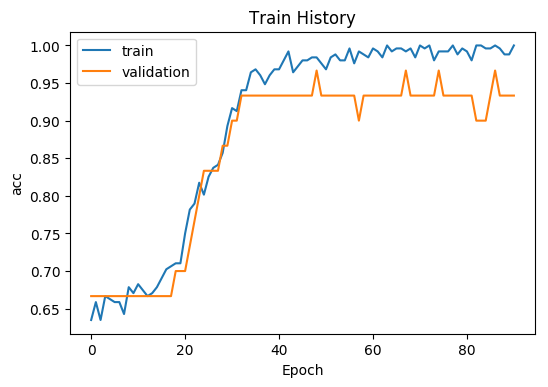

In [328]:
show_train_history(model_history,'acc','val_acc')

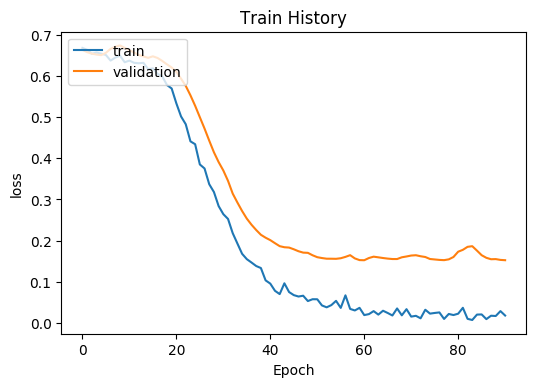

In [329]:
show_train_history(model_history,'loss','val_loss')

In [330]:
type(mapping)

pandas.core.indexes.base.Index

In [331]:
mapping_list = list(mapping)
mapping_list

['leave', 'phone', 'weather']

In [332]:
def to_cat_name(x): 
    """
    training的類別對應表
    預測數字轉文字名稱
    :param _x:
    :param _mapping_list:
    :return:
    """
    
    mapping_name_list = []
    for item in x:
        mapping_name_list.append(mapping_list[int(item)])
    return mapping_name_list
    
def predict(test):
#     model = load_model(model_path)
    y_predict_probability = model.predict(test)
    y_predict = model.predict_classes(test)

    return to_cat_name(y_predict), y_predict, to_cat_name(test), test, y_predict_probability

def predict_class(data):
    """
    結果預測
    :param _model:
    :param _data:
    :return:
    """
    
    y_predict_probability = model.predict(data, batch_size=64, verbose=1)
    predict_arr = []
    predictClass = []
    for row in y_predict_probability: 
            classIndex=0
            selectClass=0
            selectProbability=0
            for item in row: 
                #print(float(item))
                if(selectProbability <= float(item)):
                    #print(classIndex)
                    selectProbability=float(item)
                    selectClass=classIndex
                classIndex=classIndex+1
            predictClass.append(selectClass)
             
    return to_cat_name(predictClass), predictClass, y_predict_probability

y_predict_name, y_predict, y_predict_probability = predict_class(x_test)
# y_predict_name, y_predict, answer, answer_name, y_predict_probability = predict(x_test)

12/12 [==============================] - 0s 23ms/step


In [333]:
# def predict(test):
# #     model = load_model(model_path)
#     y_predict_probability = model.predict(test)
#     y_predict = model.predict_classes(test)
    
#     def to_cat_name(x): 
#         return mapping[x] 

#     return to_cat_name(y_predict), y_predict, y_predict_probability

# y_predict_name, y_predict, y_predict_probability = predict(x_test)

In [334]:
# predict = model.predict(x_test)
# len(y_predict_probability)

In [335]:
def float_display(f, float_display):

    return round(f, float_display)

In [336]:
predict_arr = []
for row in y_predict_probability:
    row_arr = []
    for item in row:
#         print(float_display(item))
        row_arr.append(float_display(item,4))
    predict_arr.append(row_arr)

In [337]:
predict_df = pd.DataFrame({'1_sentence':df_test.sentence,
              '2_y_predict':y_predict,
              '3_y_predict_name':y_predict_name,
              '4_answer':y_test,
              '5_answer_name':df_test.target,
              '6_y_predict_probability':predict_arr})

predict_df

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
0,事假,2,weather,0,leave,"[0.0178, 0.0533, 0.4429]"
1,會很熱,2,weather,2,weather,"[0.0236, 0.0182, 0.6561]"
2,帶外套,2,weather,2,weather,"[0.0137, 0.066, 0.3738]"
3,查個分機,1,phone,1,phone,"[0.0, 1.0, 0.0]"
4,狂風爆雨,2,weather,2,weather,"[0.0114, 0.0952, 0.3506]"
5,填假單,0,leave,0,leave,"[1.0, 0.0, 0.0]"
6,撥個分機,1,phone,1,phone,"[0.0, 1.0, 0.0]"
7,請公出假,1,phone,0,leave,"[0.0327, 0.1001, 0.0781]"
8,生病幫我請假,0,leave,0,leave,"[1.0, 0.0, 0.0]"
9,聯絡同事,1,phone,1,phone,"[0.0, 1.0, 0.0]"


In [338]:
answer = predict_df['4_answer']
predict =  predict_df['2_y_predict']

In [339]:
# from sklearn.metrics import confusion_matrix
# # tn, fp, fn, tp =
# confusion_matrix(predict_df['4_answer'], predict_df['2_y_predict']).ravel()
# # tn, fp, fn, tp

In [340]:
"""
accuracy.precision.recall.f1_score
"""
from sklearn.metrics import accuracy_score
print('accuracy : {0:0.2f}'.format(accuracy_score(answer, predict)))

accuracy : 0.75


In [341]:
from sklearn.metrics import precision_recall_fscore_support
precision_score, recall_score, f1_score, support = precision_recall_fscore_support(answer, predict, average='macro')
print('precision_score : {0:0.2f}'.format(precision_score))
print('recall_score : {0:0.2f}'.format(recall_score))
print('f1_score : {0:0.2f}'.format(f1_score))

precision_score : 0.80
recall_score : 0.77
f1_score : 0.74


In [342]:
## only binary class
# from sklearn.metrics import roc_auc_score
# roc_auc_score(answer, predict)

In [343]:
predict_df[predict_df['2_y_predict'] != predict_df['4_answer']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability
0,事假,2,weather,0,leave,"[0.0178, 0.0533, 0.4429]"
7,請公出假,1,phone,0,leave,"[0.0327, 0.1001, 0.0781]"
11,幫我查天氣後再打電話,1,phone,2,weather,"[0.0, 0.9988, 0.0007]"


In [344]:
# confusion matrix
pd.crosstab(np.array(y_predict_name), np.array(df_test.target),
            rownames=['predict'], colnames=['answer'])

answer,leave,phone,weather
predict,,,
leave,2,0,0
phone,1,3,1
weather,1,0,4


In [345]:
"""
信心值過低踢除
"""
def confuse_class(s):
    if float(max(s)) < 0.7:
        return True
            
    return False    

predict_df['7_confuse'] = predict_df['6_y_predict_probability'].apply(lambda s: confuse_class(s))
predict_df[predict_df['7_confuse']]

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability,7_confuse
0,事假,2,weather,0,leave,"[0.0178, 0.0533, 0.4429]",True
1,會很熱,2,weather,2,weather,"[0.0236, 0.0182, 0.6561]",True
2,帶外套,2,weather,2,weather,"[0.0137, 0.066, 0.3738]",True
4,狂風爆雨,2,weather,2,weather,"[0.0114, 0.0952, 0.3506]",True
7,請公出假,1,phone,0,leave,"[0.0327, 0.1001, 0.0781]",True
10,帶傘,2,weather,2,weather,"[0.0076, 0.0987, 0.5685]",True


In [346]:
predict_df

,1_sentence,2_y_predict,3_y_predict_name,4_answer,5_answer_name,6_y_predict_probability,7_confuse
0,事假,2,weather,0,leave,"[0.0178, 0.0533, 0.4429]",True
1,會很熱,2,weather,2,weather,"[0.0236, 0.0182, 0.6561]",True
2,帶外套,2,weather,2,weather,"[0.0137, 0.066, 0.3738]",True
3,查個分機,1,phone,1,phone,"[0.0, 1.0, 0.0]",False
4,狂風爆雨,2,weather,2,weather,"[0.0114, 0.0952, 0.3506]",True
5,填假單,0,leave,0,leave,"[1.0, 0.0, 0.0]",False
6,撥個分機,1,phone,1,phone,"[0.0, 1.0, 0.0]",False
7,請公出假,1,phone,0,leave,"[0.0327, 0.1001, 0.0781]",True
8,生病幫我請假,0,leave,0,leave,"[1.0, 0.0, 0.0]",False
9,聯絡同事,1,phone,1,phone,"[0.0, 1.0, 0.0]",False


In [347]:
predict_df[predict_df['1_sentence'] =='幫我預測NBA冠軍']['6_y_predict_probability']

Series([], Name: 6_y_predict_probability, dtype: object)

In [348]:
pppp

NameError: name 'pppp' is not defined

# 訓練模型 -上線模型

In [ ]:
"""
訓練model
"""
# # set parameters:
# # GPU
# batch_size = 32
# filters = 200
# kernel_size = 3
# epochs = 300
# train_ratio = 0.9
# embedding_dim = 256

# batch_size = 20
# filters = 200
# kernel_size = 3
# epochs = 250 #800
# train_ratio = 0.9
# model = build_2dcnn_model(num_classes, NUM_WORDS, MAX_LEN)

batch_size = 20
filters = 200
kernel_size = 3
epochs = 100 #800
train_ratio = 0.9

model = build_1DCNN_model(num_classes, NUM_WORDS, MAX_LEN, kernel_size)

# batch_size = 20
# filters = 200
# kernel_size = 3
# epochs = 50 #800
# train_ratio = 0.9
# embedding_dim = 128
# model = build_text_cnn(num_classes, NUM_WORDS, MAX_LEN, embedding_dim)

# optimizers.Adam(lr=0.001, beta_1=0.6, beta_2=0.099,
#                 epsilon=1e-08, decay=0.005, clipnorm = 1., clipvalue = 0.5)
# model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy',metrics=['accuracy'])

# batch_size = 10
# filters = 200
# kernel_size = 3
# epochs = 250 #800
# train_ratio = 0.9

# model = build_SimpleRNN_model(num_classes, NUM_WORDS, MAX_LEN, kernel_size)

# model.compile(optimizer='Adam', 
#               loss='categorical_crossentropy', 
#               metrics=['accuracy'])

# 使用數字標籤當label, 不用轉onehot
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
from datetime import datetime
train_start = datetime.now()
earlystop = EarlyStopping(monitor='val_loss', patience=30)
# history = LossHistory()
model_history = model.fit(x=x_train, y=y_train,
                            batch_size=batch_size, 
                            epochs=epochs,
                            validation_split= 1 - train_ratio,
                            callbacks = [earlystop])

train_end = datetime.now()
train_duration = str(train_end - train_start)
print(train_duration)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print('loss : {}'.format(loss))
print('accuracy : {}'.format(accuracy))

In [ ]:
show_train_history(model_history,'acc','val_acc')

In [ ]:
show_train_history(model_history,'loss','val_loss')

In [ ]:
# model.save('{}.h5'.format('model/model_intent'))